In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/IA_et_application/

In [ ]:
%cd  /content/drive/MyDrive/IA_et_application/Dataset/vesuvius-challenge-ink-detection/

/content/drive/MyDrive/IA_et_application/Dataset/vesuvius-challenge-ink-detection


#imports

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import PIL.Image as Image
import torch.utils.data as data
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm
from ipywidgets import interact, fixed

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import time

In [ ]:
first_train_images_data = '/content/drive/MyDrive/IA_et_application/Dataset/vesuvius-challenge-ink-detection/train/1/'

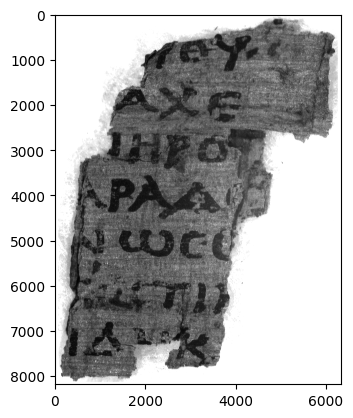

In [ ]:
BUFFER = 32  # Buffer size in x and y direction
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
TRAINING_STEPS = 1100
LEARNING_RATE = 0.03
BATCH_SIZE = 32
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

plt.imshow(Image.open(first_train_images_data+"ir.png"), cmap="gray")

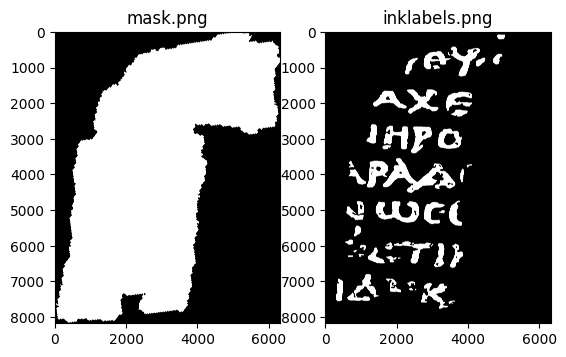

In [ ]:
mask = np.array(Image.open(first_train_images_data+"mask.png"))
label = torch.from_numpy(np.array(Image.open(first_train_images_data+"inklabels.png"))).gt(0).float().to(DEVICE)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title("mask.png")
ax1.imshow(mask, cmap='gray')
ax2.set_title("inklabels.png")
ax2.imshow(label.cpu(), cmap='gray')
plt.show()

In [ ]:
Z_START = 0 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


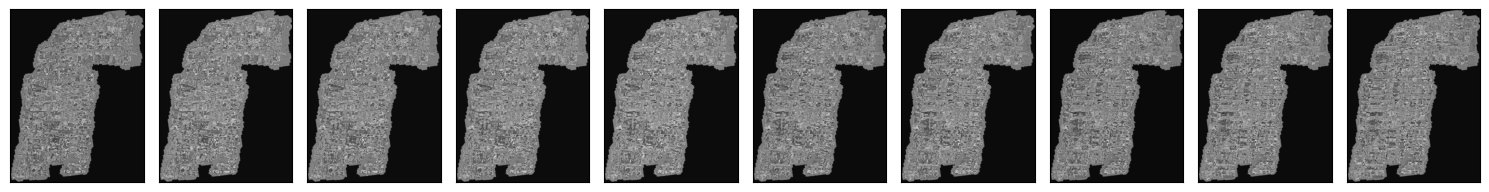

In [ ]:
# Load the 3d x-ray scan, one slice at a time
images = [np.array(Image.open(filename), dtype=np.float32)/65535.0 for filename in tqdm(sorted(glob.glob(first_train_images_data+"surface_volume/*.tif"))[Z_START:Z_START+Z_DIM])]
image_stack = torch.stack([torch.from_numpy(image) for image in images], dim=0).to(DEVICE)

fig, axes = plt.subplots(1, len(images), figsize=(15, 3))
for image, ax in zip(images, axes):
  ax.imshow(np.array(Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
  ax.set_xticks([]); ax.set_yticks([])
fig.tight_layout()
plt.show()

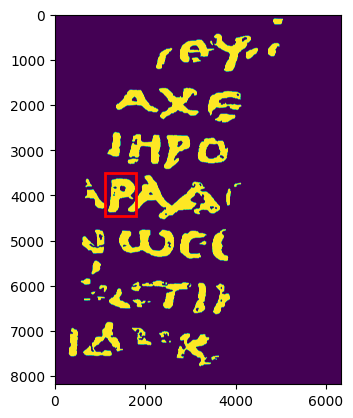

In [ ]:
# Définition des coordonnées du rectangle : (x, y, width, height)
rect = (1100, 3500, 700, 950)
fig, ax = plt.subplots()
ax.imshow(label.cpu())
patch = patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(patch)
plt.show()

#fonction pour charger les images d'entrainement (1,2,3)

In [ ]:
DATA_DIR = '/content/drive/MyDrive/IA_et_application/Dataset/vesuvius-challenge-ink-detection/'
SHARED_HEIGHT = 4000

In [ ]:
def resize(img):
    current_width, current_height = img.size
    aspect_ratio = current_width / current_height
    new_width = int(SHARED_HEIGHT * aspect_ratio)
    new_size = (new_width, SHARED_HEIGHT)
    img = img.resize(new_size)
    return img

def load_mask(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/mask.png").convert('1')
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

def load_labels(split, index):
    img = Image.open(f"{DATA_DIR}/{split}/{index}/inklabels.png")
    img = resize(img)
    return tf.convert_to_tensor(img, dtype="bool")

In [ ]:
mask_test_a = load_mask(split="test", index="a")
mask_test_b = load_mask(split="test", index="b")

mask_train_1 = load_mask(split="train", index=1)
labels_train_1 = load_labels(split="train", index=1)

mask_train_2 = load_mask(split="train", index=2)
labels_train_2 = load_labels(split="train", index=2)

mask_train_3 = load_mask(split="train", index=3)
labels_train_3 = load_labels(split="train", index=3)

print(f"mask_test_a: {mask_test_a.shape}")
print(f"mask_test_b: {mask_test_b.shape}")
print("-")
print(f"mask_train_1: {mask_train_1.shape}")
print(f"labels_train_1: {labels_train_1.shape}")
print("-")
print(f"mask_train_2: {mask_train_2.shape}")
print(f"labels_train_2: {labels_train_2.shape}")
print("-")
print(f"mask_train_3: {mask_train_3.shape}")
print(f"labels_train_3: {labels_train_3.shape}")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3167: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


mask_test_a: (4000, 9284)
mask_test_b: (4000, 4642)
-
mask_train_1: (4000, 3094)
labels_train_1: (4000, 3094)
-
mask_train_2: (4000, 2563)
labels_train_2: (4000, 2563)
-
mask_train_3: (4000, 2760)
labels_train_3: (4000, 2760)


#afficher les labels de l'entrainement

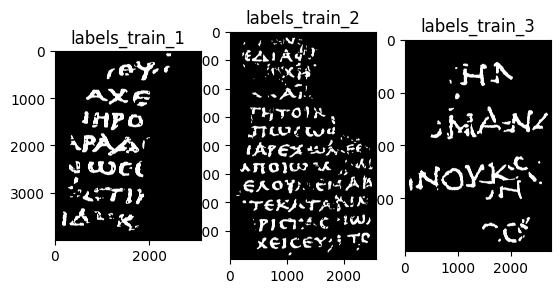

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)

ax1.set_title("labels_train_1")
ax1.imshow(labels_train_1, cmap='gray')

ax2.set_title("labels_train_2")
ax2.imshow(labels_train_2, cmap='gray')

ax3.set_title("labels_train_3")
ax3.imshow(labels_train_3, cmap='gray')

plt.show()

#fonctions pour charger les volumes

In [ ]:
def load_volume(split, index):
    # Load les scans 3d rayon x, une à la fois
    z_slices_fnames = sorted(glob.glob(f"{DATA_DIR}/{split}/{index}/surface_volume/*.tif"))[Z_START:Z_START + Z_DIM]
    z_slices = []
    for z, filename in  tqdm(enumerate(z_slices_fnames)):
        img = Image.open(filename)
        img = resize(img)
        z_slice = np.array(img, dtype="float32")
        z_slices.append(z_slice)
    return tf.stack(z_slices, axis=-1)

In [ ]:
volume_train_1 = load_volume(split="train", index=1)
print(f"volume_train_1: {volume_train_1.shape}, {volume_train_1.dtype}")

volume_train_2 = load_volume(split="train", index=2)
print(f"volume_train_2: {volume_train_2.shape}, {volume_train_2.dtype}")

volume_train_3 = load_volume(split="train", index=3)
print(f"volume_train_3: {volume_train_3.shape}, {volume_train_3.dtype}")

volume = tf.concat([volume_train_1, volume_train_2, volume_train_3], axis=1)
print(f"total volume: {volume.shape}")

10it [00:37,  3.72s/it]


volume_train_1: (4000, 3094, 10), <dtype: 'float32'>


10it [01:16,  7.67s/it]


volume_train_2: (4000, 2563, 10), <dtype: 'float32'>


10it [00:30,  3.08s/it]


volume_train_3: (4000, 2760, 10), <dtype: 'float32'>
total volume: (4000, 8417, 10)


In [ ]:
del volume_train_1
del volume_train_2
del volume_train_3

#concaténer les labels et les masques sur une même image

In [ ]:
labels = tf.concat([labels_train_1, labels_train_2, labels_train_3], axis=1)
print(f"labels: {labels.shape}, {labels.dtype}")

mask = tf.concat([mask_train_1, mask_train_2, mask_train_3], axis=1)
print(f"mask: {mask.shape}, {mask.dtype}")

labels: (4000, 8417), <dtype: 'bool'>
mask: (4000, 8417), <dtype: 'bool'>


In [ ]:
# Free up memory
del labels_train_1
del labels_train_2
del labels_train_3
del mask_train_1
del mask_train_2
del mask_train_3

#selection une zone de validation

In [ ]:
# Définition des coordonnées du rectangle : (x, y, width, height)
rect = (1100, 1100, 400, 700)

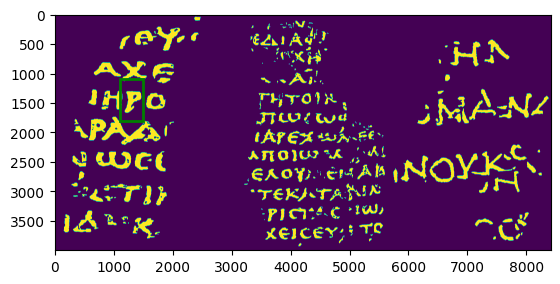

In [ ]:
fig, ax = plt.subplots()
ax.imshow(labels)
patch = patches.Rectangle((rect[1], rect[0]), rect[2], rect[3], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(patch)
plt.show()

#Créer un dataset où l'on va donner des positions aléatoires

In [ ]:
def sample_random_location(shape):
    random_train_x = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[0] - BUFFER - 1, dtype="int32")
    random_train_y = tf.random.uniform(shape=(), minval=BUFFER, maxval=shape[1] - BUFFER - 1, dtype="int32")
    random_train_location = tf.stack([random_train_x, random_train_y])
    return random_train_location

def is_in_masked_zone(location, mask):
    return mask[location[0], location[1]]

sample_random_location_train = lambda x: sample_random_location(mask.shape)
is_in_mask_train = lambda x: is_in_masked_zone(x, mask)

In [ ]:
def is_in_val_zone(location,rectangle):
  x = location[0]
  y = location[1]
  x_match = rectangle[0] - BUFFER <= x <= rectangle[0] + rectangle[3] + BUFFER
  y_match = rectangle[1] - BUFFER <= y <= rectangle[1] + rectangle[2] + BUFFER

  return x_match and y_match

In [ ]:
def is_proper_train_location(location):
    return not is_in_val_zone(location, rect) and is_in_mask_train(location)

In [ ]:
train_locations_ds = tf.data.Dataset.from_tensor_slices([0]).repeat().map(sample_random_location_train, num_parallel_calls=tf.data.AUTOTUNE)
train_locations_ds = train_locations_ds.filter(is_proper_train_location)

#Visualisation des patches

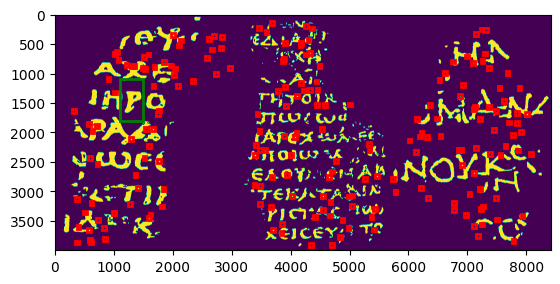

In [ ]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in train_locations_ds.take(200):
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(patch)

val_patch = patches.Rectangle((rect[1], rect[0]), rect[2], rect[3], linewidth=2, edgecolor='g', facecolor='none')
ax.add_patch(val_patch)
plt.show()

In [ ]:
def extract_subvolume(location, volume):
    x = location[0]
    y = location[1]
    subvolume = volume[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER, :]
    subvolume = tf.cast(subvolume, dtype="float32") / 65535.
    return subvolume

In [ ]:
def extract_labels(location, labels):
    x = location[0]
    y = location[1]
    label = labels[x-BUFFER:x+BUFFER, y-BUFFER:y+BUFFER]
    label = tf.cast(label, dtype="float32")
    label = tf.expand_dims(label, axis=-1)
    return label

In [ ]:
def extract_subvolume_and_label(location):
    subvolume = extract_subvolume(location, volume)
    label = extract_labels(location, labels)
    return subvolume, label

In [ ]:
shuffle_buffer_size = BATCH_SIZE * 4

train_ds = train_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

In [ ]:
for subvolume_batch, label_batch in train_ds.take(1):
    print(f"subvolume shape: {subvolume_batch.shape[1:]}")
    print(f"label_batch shape: {label_batch.shape[1:]}")

subvolume shape: (64, 64, 10)
label_batch shape: (64, 64, 1)


In [ ]:
t0 = time.time()
n = 200
for _ in train_ds.take(n):
    pass
print(f"Time per batch: {(time.time() - t0) / n:.4f}s")

Time per batch: 0.0124s


#crée le dataset de validation

In [ ]:
val_locations_stride = BUFFER
val_locations = []
for x in range(rect[0], rect[0] + rect[3], val_locations_stride):
    for y in range(rect[1], rect[1] + rect[2], val_locations_stride):
        val_locations.append((x, y))

val_locations_ds = tf.data.Dataset.from_tensor_slices(val_locations).filter(is_in_mask_train)
val_ds = val_locations_ds.map(extract_subvolume_and_label, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE).batch(BATCH_SIZE)

#visualisation

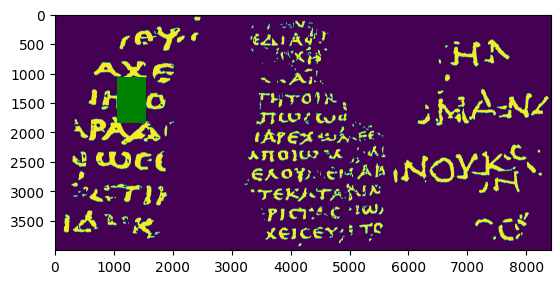

In [ ]:
fig, ax = plt.subplots()
ax.imshow(labels)

for x, y in val_locations_ds:
    patch = patches.Rectangle([y - BUFFER, x - BUFFER], 2 * BUFFER, 2 * BUFFER, linewidth=2, edgecolor='g', facecolor='none')
    ax.add_patch(patch)
plt.show()

In [ ]:
def trivial_baseline(dataset):
    total = 0
    matches = 0.
    for _, batch_label in tqdm(dataset):
        matches += tf.reduce_sum(tf.cast(batch_label, "float32"))
        total += tf.reduce_prod(tf.shape(batch_label))
    return 1. - matches / tf.cast(total, "float32")

score = trivial_baseline(val_ds).numpy()
print(f"Best validation score achievable trivially: {score * 100:.2f}% accuracy")

9it [00:01,  8.00it/s]

Best validation score achievable trivially: 74.64% accuracy


In [ ]:
augmenter = keras.Sequential([
    layers.RandomContrast(0.2),
])

def augment_train_data(data, label):
    data = augmenter(data)
    return data, label

augmented_train_ds = train_ds.map(augment_train_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(tf.data.AUTOTUNE)

In [ ]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)

    x = inputs

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(1, 3, activation="sigmoid", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

#premier modèle : disponible sur le notebook Kaggle

In [ ]:
keras.mixed_precision.set_global_policy('mixed_float16')

model = get_model((BUFFER * 2, BUFFER * 2, Z_DIM))
model.summary()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"],jit_compile=False)

history = model.fit(augmented_train_ds, validation_data=val_ds, epochs=20, steps_per_epoch=1000)
model.save("U_net_model_ink.keras")

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 64, 64, 10)]         0         []                            
                                                                                                  
 conv2d_14 (Conv2D)          (None, 32, 32, 64)           5824      ['input_3[0][0]']             
                                                                                                  
 batch_normalization_22 (Ba  (None, 32, 32, 64)           256       ['conv2d_14[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_20 (Activation)  (None, 32, 32, 64)           0         ['batch_normalization_22

#afficher les courbes de train et validation

In [ ]:
def plot_training_validation_accuracy(history):
  plt.figure(figsize=(15, 6))
  plt.plot(history.history['accuracy'],'-r', label='Training')
  plt.plot(history.history['val_accuracy'], '-b', label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()
  plt.show()

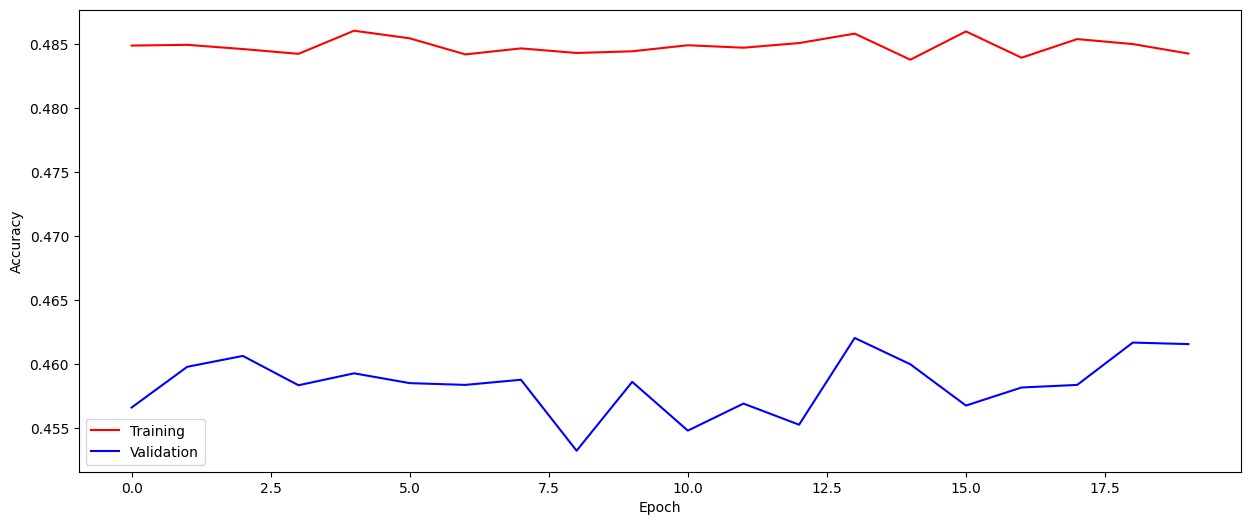

In [ ]:
plot_training_validation_accuracy(history)

#2 deuxième modèle: U-net (incomplet) il manque la couche de bottleneck et skip connections

U-Net :

L'architecture U-Net est un réseau de neurones convolutif (CNN) utilisé principalement pour la segmentation d'images médicales.

Encoder : La partie supérieure du U capture les informations de l'image à différentes échelles à l'aide de couches de convolution et de pooling, réduisant la résolution spatiale mais augmentant la profondeur.

Bottleneck : La partie centrale du U agit comme une sorte de pont entre l'encodeur et le décodeur, conservant les informations importantes tout en réduisant la dimensionnalité.

Decoder : La partie inférieure du U utilise des couches de transposition de convolution pour restaurer la résolution spatiale tout en conservant des informations importantes.

Skip Connections : Des connexions "skip" sont établies entre les couches correspondantes de l'encodeur et du décodeur, permettant au réseau de conserver des informations contextuelles importantes.

In [ ]:
from tensorflow.keras import layers, models

def create_second_model(input_shape):
    model = models.Sequential()

    # Encoder
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2), strides=(2, 2)))

    # Decoder
    model.add(layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D((2, 2)))

    model.add(layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.UpSampling2D((2, 2)))

    # Output layer
    model.add(layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

    return model

In [ ]:
second_model = create_second_model((BUFFER * 2, BUFFER * 2, Z_DIM))
second_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        5824      
                                                                 
 batch_normalization (Batch  (None, 64, 64, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 128)       512       
 chNormalization)                                                
                                                      

In [ ]:
second_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
second_history= second_model.fit(augmented_train_ds, validation_data=val_ds, epochs=20, steps_per_epoch=1000)


Epoch 1/20
1000/1000 [==============================] - 34s 25ms/step - loss: 0.4469 - accuracy: 0.8321 - val_loss: 0.6376 - val_accuracy: 0.7464
Epoch 2/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.4280 - accuracy: 0.8416 - val_loss: 0.5931 - val_accuracy: 0.7263
Epoch 3/20
1000/1000 [==============================] - 25s 25ms/step - loss: 0.4252 - accuracy: 0.8422 - val_loss: 0.5991 - val_accuracy: 0.7464
Epoch 4/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.4228 - accuracy: 0.8426 - val_loss: 0.5757 - val_accuracy: 0.7441
Epoch 5/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.4284 - accuracy: 0.8389 - val_loss: 0.6422 - val_accuracy: 0.7463
Epoch 6/20
1000/1000 [==============================] - 23s 23ms/step - loss: 0.4245 - accuracy: 0.8408 - val_loss: 0.6600 - val_accuracy: 0.7463
Epoch 7/20
1000/1000 [==============================] - 24s 24ms/step - loss: 0.4220 - accuracy: 0.8405 - val_loss: 0.6243 -

NameError: name 'model' is not defined

In [ ]:
def plot_training_validation_loss(history):
  plt.figure(figsize=(15, 6))
  plt.plot(history.history['loss'],'-r', label='Training')
  plt.plot(history.history['val_loss'], '-b', label='Validation')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

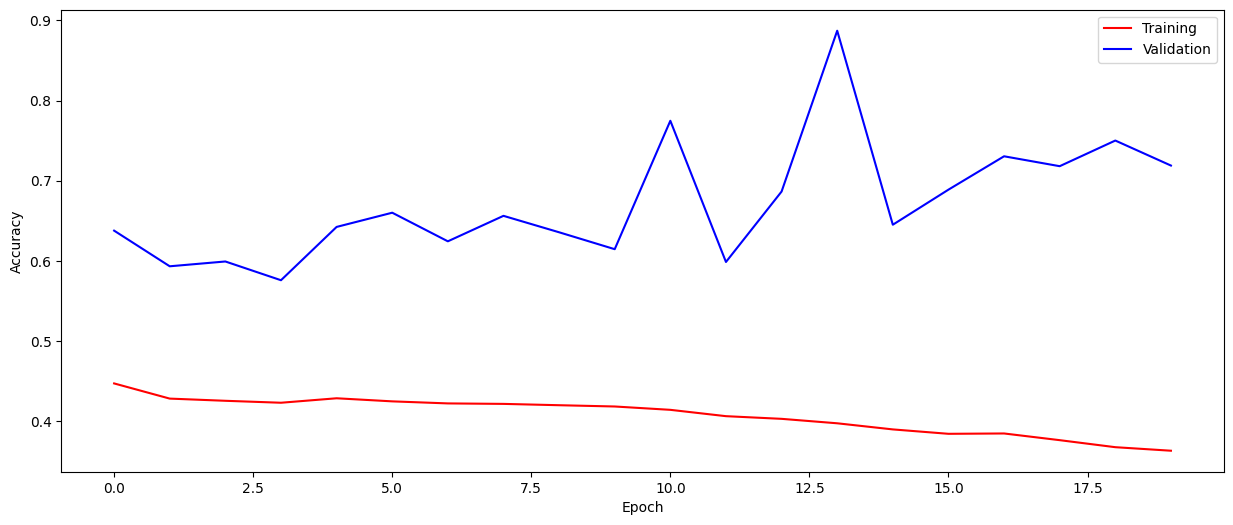

In [ ]:
plot_training_validation_loss(second_history)

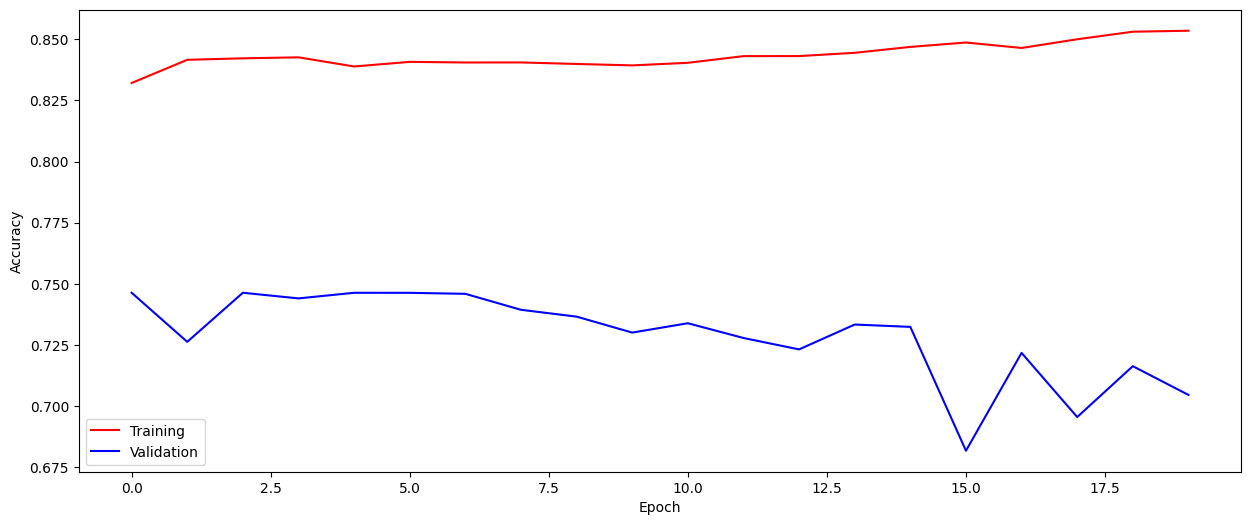

In [ ]:
plot_training_validation_accuracy(second_history)

In [ ]:
second_model.save("second_U_net_model_ink.keras")

#si on relance la session et que l'on veut utiliser le modèle

In [ ]:
second_model = keras.models.load_model("second_U_net_model_ink.keras")

NameError: name 'keras' is not defined

#3e modèle : U-net complet

In [ ]:
from tensorflow.keras import layers, models

def create_unet_complete(input_shape):
    # Encoder
    inputs = layers.Input(input_shape)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = layers.BatchNormalization()(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    # Bottleneck
    bottleneck = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    bottleneck = layers.BatchNormalization()(bottleneck)
    bottleneck = layers.Conv2D(512, 3, activation='relu', padding='same')(bottleneck)
    bottleneck = layers.BatchNormalization()(bottleneck)

    # Decoder
    upconv3 = layers.UpSampling2D(size=(2, 2))(bottleneck)
    concat3 = layers.Concatenate()([conv3, upconv3])
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(concat3)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    upconv2 = layers.UpSampling2D(size=(2, 2))(conv4)
    concat2 = layers.Concatenate()([conv2, upconv2])
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(concat2)
    conv5 = layers.BatchNormalization()(conv5)
    conv5 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv5)
    conv5 = layers.BatchNormalization()(conv5)

    upconv1 = layers.UpSampling2D(size=(2, 2))(conv5)
    concat1 = layers.Concatenate()([conv1, upconv1])
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(concat1)
    conv6 = layers.BatchNormalization()(conv6)
    conv6 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv6)
    conv6 = layers.BatchNormalization()(conv6)

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(conv6)

    # Define the model
    model = models.Model(inputs, outputs)

    return model

In [ ]:
third_model = create_unet_complete((BUFFER * 2, BUFFER * 2, Z_DIM))
third_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 10)]         0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           5824      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv2d_1 (Conv2D)           (None, 64, 64, 64)           36928     ['batch_normalization[0][0

In [ ]:
third_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
third_history = third_model.fit(augmented_train_ds, validation_data=val_ds, epochs=20, steps_per_epoch=1000)
third_model.save("complete_u_net_third_model_ink.keras")

Epoch 1/20
1000/1000 [==============================] - 128s 108ms/step - loss: 0.4209 - accuracy: 0.8318 - val_loss: 0.5616 - val_accuracy: 0.7469
Epoch 2/20
1000/1000 [==============================] - 103s 103ms/step - loss: 0.3597 - accuracy: 0.8540 - val_loss: 0.6301 - val_accuracy: 0.7500
Epoch 3/20
1000/1000 [==============================] - 102s 102ms/step - loss: 0.3276 - accuracy: 0.8670 - val_loss: 0.9397 - val_accuracy: 0.7464
Epoch 4/20
1000/1000 [==============================] - 102s 102ms/step - loss: 0.2925 - accuracy: 0.8814 - val_loss: 0.6395 - val_accuracy: 0.7415
Epoch 5/20
1000/1000 [==============================] - 102s 102ms/step - loss: 0.2497 - accuracy: 0.8987 - val_loss: 0.6824 - val_accuracy: 0.7221
Epoch 6/20
1000/1000 [==============================] - 102s 102ms/step - loss: 0.2188 - accuracy: 0.9115 - val_loss: 0.8287 - val_accuracy: 0.6821
Epoch 7/20
1000/1000 [==============================] - 103s 103ms/step - loss: 0.1938 - accuracy: 0.9229 - val_

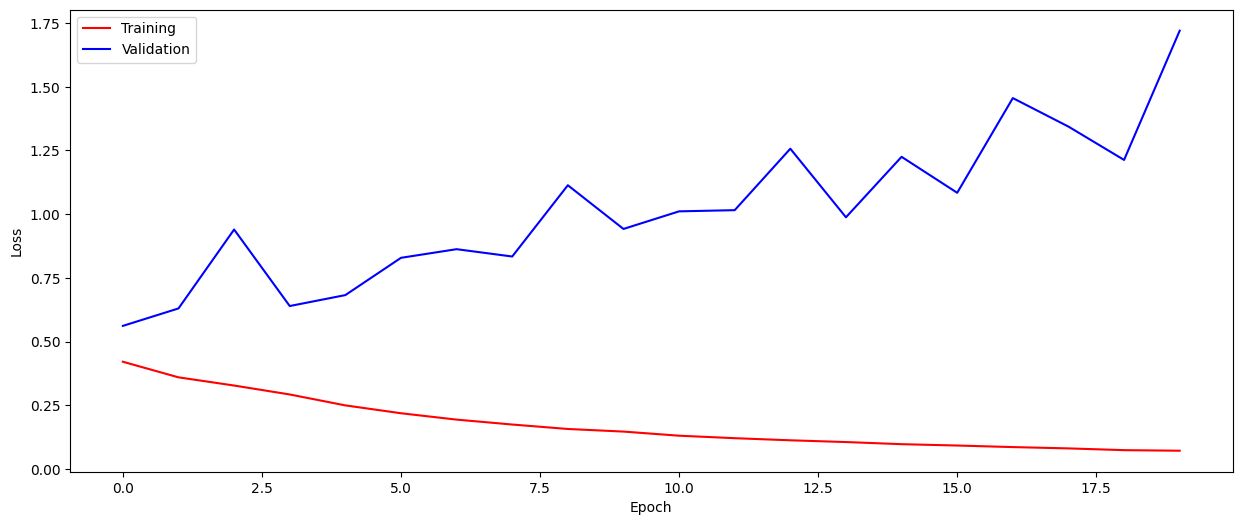

In [ ]:
plot_training_validation_loss(third_history)

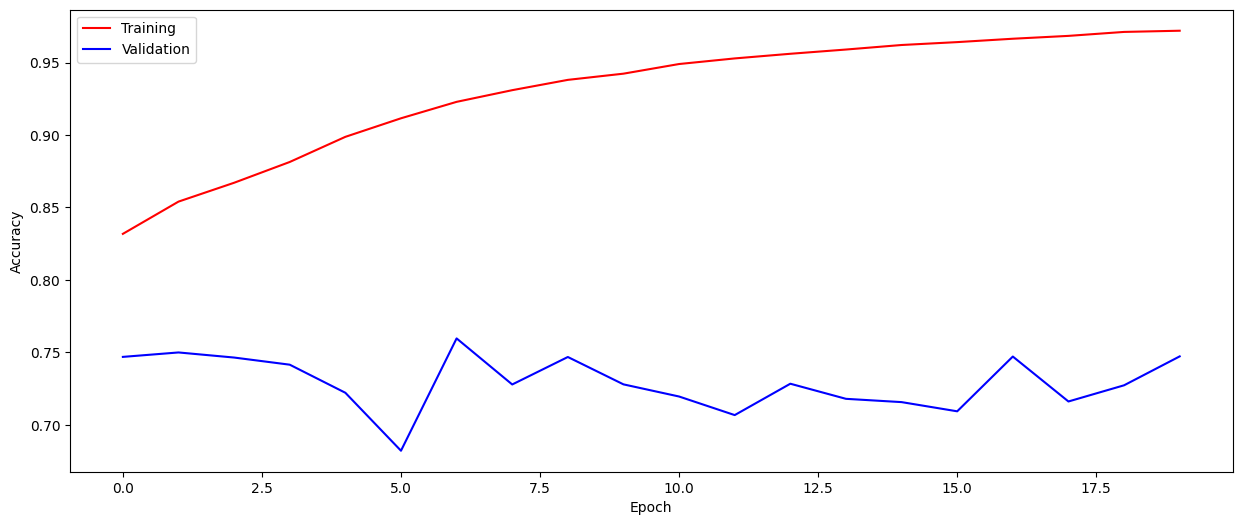

In [ ]:
plot_training_validation_accuracy(third_history)

#prédiction sur l'ensemble de test

In [ ]:
def compute_predictions_map(split, index):
    print(f"Load data for {split}/{index}")

    test_volume = load_volume(split=split, index=index)
    test_mask = load_mask(split=split, index=index)

    test_locations = []
    stride = BUFFER // 2
    for x in range(BUFFER, test_volume.shape[0] - BUFFER, stride):
        for y in range(BUFFER, test_volume.shape[1] - BUFFER, stride):
            test_locations.append((x, y))

    print(f"{len(test_locations)} test locations (before filtering by mask)")

    sample_random_location_test = lambda x: sample_random_location(test_mask.shape)
    is_in_mask_test = lambda x: is_in_masked_zone(x, test_mask)
    extract_subvolume_test = lambda x: extract_subvolume(x, test_volume)

    test_locations_ds = tf.data.Dataset.from_tensor_slices(test_locations).filter(is_in_mask_test)
    test_ds = test_locations_ds.map(extract_subvolume_test, num_parallel_calls=tf.data.AUTOTUNE)

    predictions_map = np.zeros(test_volume.shape[:2] + (1,), dtype="float16")
    predictions_map_counts = np.zeros(test_volume.shape[:2] + (1,), dtype="int8")

    print(f"Compute predictions")
    for loc_batch, patch_batch in tqdm(zip(test_locations_ds.batch(BATCH_SIZE), test_ds.batch(BATCH_SIZE))):
        #ici il faut penser à choisir le bon modèle
        #si second modèle:
        #predictions = second_model.predict_on_batch(patch_batch)
        #si troisième modèle :
        predictions = third_model.predict_on_batch(patch_batch)
        for (x, y), pred in zip(loc_batch, predictions):
            predictions_map[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += pred
            predictions_map_counts[x - BUFFER : x + BUFFER, y - BUFFER : y + BUFFER, :] += 1
    predictions_map /= (predictions_map_counts + 1e-7)
    return predictions_map

In [ ]:
predictions_map_a = compute_predictions_map(split="test", index="a")
predictions_map_b = compute_predictions_map(split="test", index="b")

Load data for test/a


10it [00:06,  1.47it/s]


141942 test locations (before filtering by mask)
Compute predictions


2817it [05:49,  8.05it/s]


Load data for test/b


10it [00:04,  2.40it/s]


70602 test locations (before filtering by mask)
Compute predictions


1196it [02:28,  8.03it/s]


In [ ]:
from skimage.transform import resize as resize_ski

original_size_a = Image.open(DATA_DIR + "/test/a/mask.png").size
predictions_map_a = resize_ski(predictions_map_a, (original_size_a[1], original_size_a[0])).squeeze()

original_size_b = Image.open(DATA_DIR + "/test/b/mask.png").size
predictions_map_b = resize_ski(predictions_map_b, (original_size_b[1], original_size_b[0])).squeeze()

#visualisation des masques prédits par les deux modèles U-net (2e modèle et 3e modèle)

## 2e modèle

In [ ]:
def plot_predicted_masks(predictions_map):
    print(predictions_map.shape)  # Ajoute cette ligne pour voir les dimensions
    # Redimensionne si nécessaire
    if len(predictions_map.shape) > 2:
        predictions_map = predictions_map[:, :, 0]

    plt.imshow(predictions_map, cmap="gray")
    plt.title("Masque prédit")
    plt.show()

(2727, 6330)


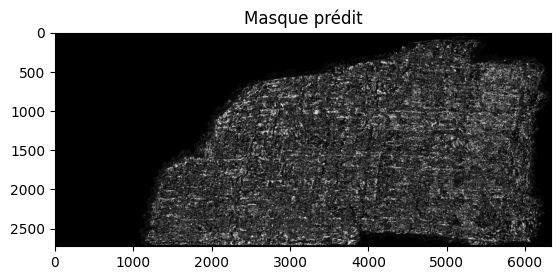

In [ ]:
plot_predicted_masks(predictions_map_a)

In [ ]:
type(predictions_map_a)

numpy.ndarray

(5454, 6330)


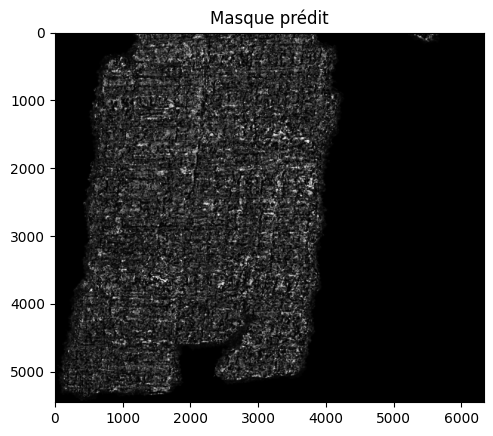

In [ ]:
plot_predicted_masks(predictions_map_b)

##3e modèle

(2727, 6330)


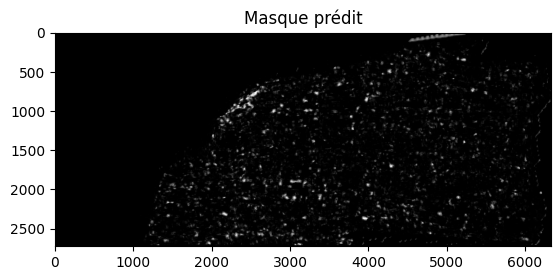

In [ ]:
plot_predicted_masks(predictions_map_a)

(5454, 6330)


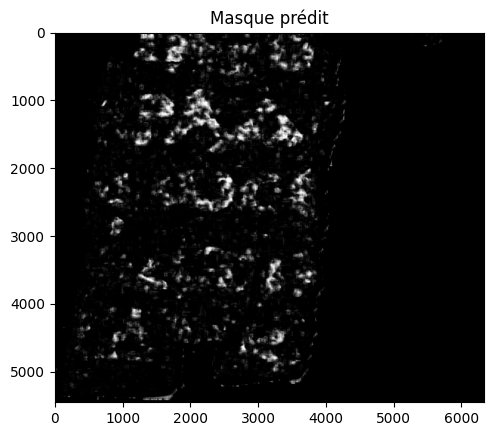

In [ ]:
plot_predicted_masks(predictions_map_b)

#evaluer les masques prédits avec IOU,Accuracy,Precision

IoU  explication :
Définition : L'IoU mesure la similarité entre deux ensembles en calculant le rapport de l'intersection de ces ensembles sur leur union.
Interprétation : Une valeur d'IoU proche de 1 indique une forte superposition entre les ensembles, ce qui est généralement souhaitable dans des tâches comme la segmentation d'images. Un IoU de 0 signifie qu'il n'y a aucune superposition entre les ensembles.

Precision explication :
Elle permet de connaître le nombre de prédictions positifs bien effectuées.

En d’autres termes c’est le nombre de positifs bien prédit (Vrai Positif) divisé par l’ensemble des positifs prédit (Vrai Positif + Faux Positif).

Plus elle est élevé, plus le modèle de Machine Learning minimise le nombre de Faux Positif.

Quand la précision est haute, cela veut dire que la majorité des prédictions positives du modèle sont des positifs bien prédit.

In [ ]:
def calculate_iou(y_true, y_pred):
    intersection = np.sum(np.logical_and(y_true, y_pred))
    union = np.sum(np.logical_or(y_true, y_pred))
    iou = intersection / union
    return iou

def accuracy(y_true, y_pred):
    correct_pixels = np.sum(y_true == y_pred)
    total_pixels = y_true.size

    acc = correct_pixels / total_pixels

    return acc

def calculate_precision(y_true,y_pred):
    true_positives = np.sum((y_true == 1) & (y_pred == 1))
    false_positives = np.sum((y_true == 0) & (y_pred == 1))

    precision = true_positives / (true_positives + false_positives + 1e-7)
    return precision

##2e modèle

##evaluation sur le test A

---



In [ ]:
true_mask_a = Image.open("/content/drive/MyDrive/IA_et_application/Dataset/vesuvius-challenge-ink-detection/test/a/mask.png")
true_mask_a = np.array(true_mask_a)

In [ ]:
type(true_mask_a)

numpy.ndarray

In [ ]:
print("Coefficient IoU:",calculate_iou(true_mask_a,predictions_map_a))
print("Accuracy:",accuracy(true_mask_a,predictions_map_a))
print("Precision:",calculate_precision(true_mask_a,predictions_map_a))

Coefficient IoU: 0.969849165340061
Accuracy: 0.3558171140968757
Precision: 0.9999999967741935


## evaluation sur le test B

In [ ]:
true_mask_b = Image.open("/content/drive/MyDrive/IA_et_application/Dataset/vesuvius-challenge-ink-detection/test/b/mask.png")
true_mask_b = np.array(true_mask_b)

In [ ]:
print("Coefficient IoU:",calculate_iou(true_mask_b,predictions_map_b))
print("Accuracy:",accuracy(true_mask_b,predictions_map_b))
print("Precision:",calculate_precision(true_mask_b,predictions_map_b))

Coefficient IoU: 0.9589599214101989
Accuracy: 0.4465950755159771
Precision: 0.9999999992592593


#3e modèle

##evaluation sur le test A

In [ ]:
true_mask_a = Image.open("/content/drive/MyDrive/IA_et_application/Dataset/vesuvius-challenge-ink-detection/test/a/mask.png")
true_mask_a = np.array(true_mask_a)

In [ ]:
print("Coefficient IoU:",calculate_iou(true_mask_a,predictions_map_a))
print("Accuracy:",accuracy(true_mask_a,predictions_map_a))
print("Precision:",calculate_precision(true_mask_a,predictions_map_a))

Coefficient IoU: 0.969849165340061
Accuracy: 0.3558170561658588
Precision: 0.9999999966666666


## evaluation sur le test B

In [ ]:
true_mask_b = Image.open("/content/drive/MyDrive/IA_et_application/Dataset/vesuvius-challenge-ink-detection/test/b/mask.png")
true_mask_b = np.array(true_mask_b)

In [ ]:
print("Coefficient IoU:",calculate_iou(true_mask_b,predictions_map_b))
print("Accuracy:",accuracy(true_mask_b,predictions_map_b))
print("Precision:",calculate_precision(true_mask_b,predictions_map_b))

Coefficient IoU: 0.9589605494921513
Accuracy: 0.4465933665509784
Precision: 0.9999999986842106
